In [0]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [0]:
# RMSLE in natural log 
def my_loss(pred, actual):
  assert len(pred) == len(actual)
  error2 = [(math.log(pred[i] + 1) - math.log(actual[i] - 1))**2 for i in len(pred)]
  result = np.sqrt(np.sum(error2) / len(pred))
  return result 

## Load the data

In [0]:
# Import the all dataset
tr = pd.read_csv('train_2.csv')

In [0]:
tr.shape

(3000, 353)

In [0]:
y = tr.revenue_log 
X = tr.drop('revenue_log', axis = 1)

In [0]:
X.shape

(3000, 352)

In [0]:
te = pd.read_csv('test_2.csv')
te.shape

(4398, 352)

In [0]:
X.shape

(3000, 352)

## Additional preprocessing

In [0]:
# Additional preprocessing (if neccesssary)
# Dimension Reduction 



In [0]:
# Split into train and Valid set
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = .2, random_state = 36)

In [0]:
print("The size of the train set ", X_tr.shape)
print("The size of the validation set ", X_val.shape)
print("The size of the test set ", te.shape)

The size of the train set  (2400, 352)
The size of the validation set  (600, 352)
The size of the test set  (4398, 352)


In [0]:
del tr, X, y, 

In [0]:
X_tr.columns

Index(['runtime_h', 'runtime_m', 'runtime_log', 'budget_log', 'popularity_log',
       'status', 'is_collection', 'is_homepage', 'n_genres', 'n_prod_comp',
       ...
       'crew_Camera', 'crew_Costume & Make-Up', 'crew_Crew', 'crew_Directing',
       'crew_Editing', 'crew_Lighting', 'crew_Production', 'crew_Sound',
       'crew_Visual Effects', 'crew_Writing'],
      dtype='object', length=352)

### 1. Elastic-Net

In [0]:
X_tr.fillna(-1, inplace = True)
X_val.fillna(-1, inplace = True)
te.fillna(-1, inplace = True)

In [0]:
from sklearn.linear_model import ElasticNet 
model_el = ElasticNet(alpha = .03, l1_ratio = .05, max_iter = 2000)
model_el.fit(X_tr, y_tr)

ElasticNet(alpha=0.03, copy_X=True, fit_intercept=True, l1_ratio=0.05,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
el_pred = model_el.predict(X_val)

In [0]:
np.sqrt(mean_squared_error(y_val, el_pred))

2.1266072116373356

In [0]:
# 1st try: 2.1347
# 2nd try: 2.1266

In [0]:
my_loss()

### 2. Random Forest 


In [0]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators= 10000, 
                                 max_depth = 5, 
                                 min_samples_split = .7, 
                                 min_samples_leaf = .3)
model_rf.fit(X_tr, y_tr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.3, min_samples_split=0.7,
           min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = model_rf.predict(X_val)

In [0]:
np.sqrt(mean_squared_error(y_val, y_pred))

2.941005964839086

In [0]:
df = pd.DataFrame(columns = ['y_val', 'y_pred'])
df.y_val = y_val
df.y_pred = y_pred
df.head()

,y_val,y_pred
2135,20.767966,15.952474
2546,18.281419,15.952474
1770,15.765057,15.952474
2857,15.687313,15.952474
1536,16.588251,15.952474


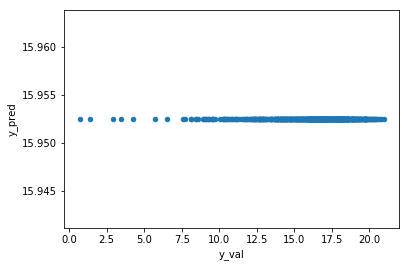

In [0]:
df.plot.scatter(x = 'y_val', y = 'y_pred')

### 3. Xgboost

In [0]:
import xgboost as xgb
model_xg = xgb.XGBRegressor(objective = 'reg:linear',
                            max_depth = 7, 
                            learning_rate = 0.01, 
                            n_estimators = 10000, 
                            early_stopping_rounds = 200,
                            gamma = 1.5,  
                            silent = True,
                            subsample = 0.7, 
                            colsample_bytree = 0.7, 
                            colsample_bylevel = 0.5)
model_xg.fit(X_tr, y_tr)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.7, early_stopping_rounds=200, gamma=1.5,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [0]:
xg_pred = model_xg.predict(X_val)

In [0]:
np.sqrt(mean_squared_error(y_val, xg_pred))

1.9128539311894288

In [0]:
# 1st try: 1.92025
# 2nd try: 1.91285

### 4. Catboost

In [0]:
from catboost import CatBoostRegressor

In [0]:
model_cb = CatBoostRegressor(iterations = 10000,
                             depth = 7,
                             eval_metric = 'RMSE',
                             learning_rate = .01,
                             subsample = 0.7, 
                             colsample_bytree = 0.7,
                             colsample_bylevel = .5,
                             bagging_temperature = .2, 
                             early_stopping_rounds = 200,
                             logging_level = 'Silent')
model_cb.fit(X_tr, y_tr, plot = True)

In [0]:
cb_pred = model_cb.predict(X_val)

In [0]:
np.sqrt(mean_squared_error(y_val, cb_pred))

1.8779128888749124

In [0]:
# 1st try: 1.92189
# 2nd try: 1.87791

### 4. Lightgbm

In [0]:
import lightgbm as lgb

In [0]:
tr_data = lgb.Dataset(X_tr, label = y_tr)

params = {'objective' : 'regression',
          'max_depth' : 7,
          #'num_leaves' : 30,
          'learning_rate': 0.01,
          'metric' : 'rmse',
          'min_data_in_leaf' : 100,
          'colsample_bytree': 0.7,
          'subsample_freq': 1,
          'lambda_l1' : 0.2,
          #'lambda_l2' : .3
          'subsample' : .7, 
          #"bagging_seed" : 42,
          "verbose" : -1}

hist = {}
model_lg = lgb.train(params, tr_data, 
                     num_iteration = 10000, 
                     early_stopping_rounds = 200,
                     callbacks = [lgb.record_evaluation(hist)])

In [0]:
pred_lg = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)

In [0]:
my_loss(pred_lg, actual)

### 5. Keras

In [0]:
import keras
from keras.models import Sequential
from Keras.layers import Dense
from keras.callbacks import EarlyStopping

In [0]:
#from keras.layers import Dropout, BatchNormalization 

#model.add(Dropout(.2))
#model.add(BatchNormalization())

In [0]:
X_tr.shape[1]

In [0]:
# initialize the model
model_ke = Sequential()

# create hidden layers
model_ke.add(Dense(input_dim = X_tr.shape[1], output_dim, 
                activation = 'relu'))
model_ke.add(Dense(output_dim, activation = 'relu'))
model_ke.add(Dense(output_dim = 1)) 

# compile: stochastic gradient descent
model_ke.compile(optimizer = 'adam', 
              loss = 'mse', 
              metrics = ['mean_squared_logarithmic_error'])

In [0]:
# early stopper 
early_stopper = EarlyStopping(patience = 5)

r = model_ke.fit(X_tr, y_tr, 
                 batch_size = 100, 
                 n_epoch = 100,
                 callbacks = [early_stopper])

In [0]:
# prediction 
pred = model_ke.predict(X_val)

In [0]:
# plot the error
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend()
plt.show()

plt.plot(r.history['mean_squared_logarithmic_error'], label = 'train mse')
plt.plot(r.history['val_mean_squared_logarithmic_error'], label = 'test mse')
plt.legend()
plt.show()

## Evaluation

In [0]:
df_pred = pd.DataFrame()

In [0]:
df_pred['el'] = model_el.predict(te)

In [0]:
df_pred['xg'] = model_xg.predict(te)
df_pred['cb'] = model_cb.predict(te)

In [0]:
df_pred['lg'] = model_lg.predict(te)

In [0]:
df_pred['ke'] = model_ke.predict(te)

In [0]:
#df_pred['final'] = np.expm1(.2*df_pred.el + .5*df_pred.cb + .3*df_pred.xg)
df_pred['final'] = np.expm1(.5*df_pred.cb + .5*df_pred.xg)

In [0]:
df_pred.head()

,xg,cb,final,el
0,16.052170,15.547183,5.807170e+06,14.926807
1,13.687190,14.855867,1.817424e+06,14.394201
2,16.181671,15.821494,6.957021e+06,14.950067
3,15.788505,15.791989,7.713922e+06,16.129956
4,13.339710,13.354093,8.466378e+05,14.850349


### Submission

In [0]:
sub = pd.read_csv('sample_submission.csv')
sub.shape

(4398, 2)

In [0]:
sub.head()

,id,revenue
0,3001,1000000
1,3002,1000000
2,3003,1000000
3,3004,1000000
4,3005,1000000


In [0]:
sub['revenue'] = df_pred.final